<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/Plant-disease/blob/master/DeteksiPenyakit_tanaman_mobilenethanyaTomat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identfikasi Penyakit Tanaman Pada Daun Tomat dan Daun Singkong**

### Melatih Model Diagnosis Penyakit Tumbuhan dengan Dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'keras.utils.np_utils'

# **Tahap Persiapan**

###Pengambilan dataset

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Bacterial_spot image/Tomato___Bacterial_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Early_blight image/Tomato___Early_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Late_blight image/Tomato___Late_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Septoria_leaf_spot image/Tomato___Septoria_leaf_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Target_Spot image/Tomato___Target_Spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___healthy image/Tomato___healthy　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_mosaic_virus image/Tomato___mosaic_virus >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Spider_mites%20Two-spotted_spider_mite image/Tomato___Spider_mites_20Two-spotted_spider_mite >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Leaf_Mold image/Tomato___Leaf_Mold >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus image/Tomato___Yellow_Leaf_Curl_Virus >  /dev/null

In [3]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls image

Tomato___Bacterial_spot　  Tomato___mosaic_virus
Tomato___Early_blight　    Tomato___Septoria_leaf_spot　
Tomato___healthy　	   Tomato___Spider_mites_20Two-spotted_spider_mite
Tomato___Late_blight　	   Tomato___Target_Spot　
Tomato___Leaf_Mold	   Tomato___Yellow_Leaf_Curl_Virus


In [4]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
base_dir = os.path.join('image')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Tomato___Bacterial_spot　','Tomato___Early_blight　','Tomato___healthy　','Tomato___Late_blight　','Tomato___Leaf_Mold','Tomato___mosaic_virus','Tomato___Septoria_leaf_spot　','Tomato___Spider_mites_20Two-spotted_spider_mite','Tomato___Target_Spot　','Tomato___Yellow_Leaf_Curl_Virus']
for i,label in enumerate(labels):
    folder = os.path.join("image",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(64,64))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 14532 images belonging to 10 classes.
Found 3628 images belonging to 10 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 64, 64, 3) (128, 10)
Bentuk array dari dataset validation (validasi) adalah: (128, 64, 64, 3) (128, 10)
Bentuk array dari dataset test (pengujian) adalah: (153, 64, 64, 3) (153,)


In [5]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Tomato___Bacterial_spot\u3000': 0, 'Tomato___Early_blight\u3000': 1, 'Tomato___Late_blight\u3000': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot\u3000': 4, 'Tomato___Spider_mites_20Two-spotted_spider_mite': 5, 'Tomato___Target_Spot\u3000': 6, 'Tomato___Yellow_Leaf_Curl_Virus': 7, 'Tomato___healthy\u3000': 8, 'Tomato___mosaic_virus': 9}


In [6]:
!cat labels.txt

Tomato___Bacterial_spot　
Tomato___Early_blight　
Tomato___Late_blight　
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot　
Tomato___Spider_mites_20Two-spotted_spider_mite
Tomato___Target_Spot　
Tomato___Yellow_Leaf_Curl_Virus
Tomato___healthy　
Tomato___mosaic_virus

# Pembuatan Arsitektur CNN

In [7]:
IMG_SHAPE = (64, 64, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

/tensorflow-2.1.0/python3.6/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step


## *Feature Extraction*

In [8]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32) 

# Pelatihan Data

## Mempersiapkan Data Masukkan Pengujian

In [0]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [10]:
model = tf.keras.Sequential([
    base_model,  
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(64,64,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 2, 2, 1024)        3228864   
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 2, 16)          147472    
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 16)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 2, 2, 32)          4640      
_________________________________________________________________
activation (Activation)      (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 2, 2, 32)          9

## Pelatihan

In [11]:
history = model.fit_generator(train_generator, 
                    epochs=50, 
                    validation_data=val_generator)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 114 steps, validate for 29 steps
Epoch 1/50
114/114 [==============================] - 30s 264ms/step - loss: 0.2338 - acc: 0.9189 - val_loss: 0.2250 - val_acc: 0.9201
Epoch 2/50
114/114 [==============================] - 23s 199ms/step - loss: 0.1350 - acc: 0.9489 - val_loss: 0.2531 - val_acc: 0.9115
Epoch 3/50
114/114 [==============================] - 22s 197ms/step - loss: 0.1027 - acc: 0.9611 - val_loss: 0.2662 - val_acc: 0.9101
Epoch 4/50
114/114 [==============================] - 22s 195ms/step - loss: 0.0795 - acc: 0.9706 - val_loss: 0.2992 - val_acc: 0.9036
Epoch 5/50
114/114 [==============================] - 23s 200ms/step - loss: 0.0614 - acc: 0.9773 - val_loss: 0.3505 - val_acc: 0.8962
Epoch 6/50
114/114 [==============================] - 22s 196ms/step - loss: 0.0446 - acc: 0.9842 - val_loss: 0.3713 - val_acc: 0.8921
Epoch 7/50
114/114 [=

## Grafik Data Pelatihan

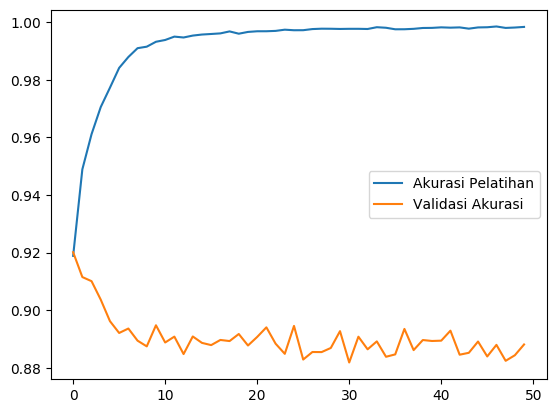

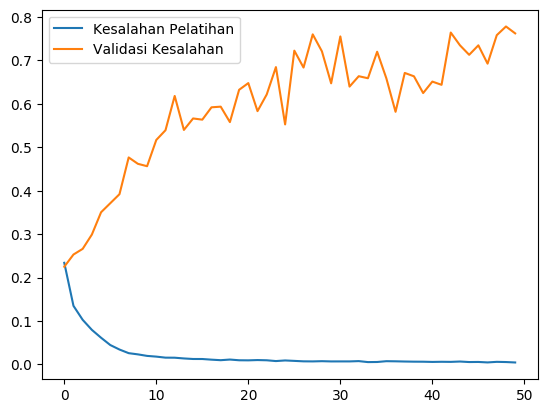

In [12]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [13]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 10


## Menggunakan Model

In [14]:
print(train_generator)

In [15]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediksinya adalah [1.18356875e-05 8.11272366e-06 4.81716324e-06 1.76321453e-04
 1.63546094e-04 9.96241943e-06 1.25593433e-05 2.00246996e-06
 6.92797403e-06 9.98762250e-01]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Cilamaya, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, 1 filter dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

# Evaluasi

In [16]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
  ...
    to  
  ['...']
114/114 [==============================] - 18s 155ms/step - loss: 0.7808 - acc: 0.8870
[0.7807927832268832, 0.8870082]
  ...
    to  
  ['...']
29/29 [==============================] - 5s 155ms/step - loss: 0.7624 - acc: 0.8881
[0.7624055558237536, 0.888065]


ValueError: ignored

In [0]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

## Prediksi Gambar Individual

In [0]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

## *Confusion Matrix*

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Konversi ke ".tflite"

Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [0]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Jenis_Beras.tflite', 'wb') as f:
  f.write(tflite_model)